# Durban Port Congestion Simulation
### **Discrete event simulation of Crane Scheduling & Yard Dwell Time**

This notebook models the flow of containers through the Durban Container Terminal using a Discrete Event Simulation (DES) approach.
The goal is to:

- Identify bottlenecks
- Model realistic delays
- Test optimisation strategies such as:
    1. Crane Scheduling Optimisation
    2. Yard Dwell Time Reduction

This notebook is structured to reflect the real-world operations of Durban Port, including:

- Offloading by STS cranes
- Yard capacity constraints
- Scanning delays (SARS)
- Truck loading
- Gate-out processing

We will build the simulation step-by-step, with explanations for each block.

In [1]:
import simpy
import random
import numpy as np
import pandas as pd

Listed above, are the core libraries for our simulation:
- simpy : Discrete event simulation engine
- random : Stochastic arrival patterns
- numpy : numerical operations
- pandas : storing and analysing the results

This is the minimal set we need to start building our model.

In [2]:
# -----------------------------
# Global Parameters (Week 1 Data)
# -----------------------------

# Cranes (STS)
NUM_CRANES = 16         # number of ship-to-shore cranes
CRANE_MOVES_PER_HOUR = 18   # container moves per crane per hour (so the cranes modeled here move 18 containers each per hour)
CRANE_TIME = 60 / CRANE_MOVES_PER_HOUR  # the time (in minutes) it takes one crane to move one container

# Yard
YARD_CAPACITY = 10000  # maximum number of container the yard can hold

# Scanners (SARS)
NUM_SCANNERS = 2    # number of scanners
SCAN_TIME = 10  # time (in minutes) to scan one container

# Truck Loading (Pier 2 baseline)
NUM_LOADING_BAYS = 20    # number of truck loading bays
LOADING_TIME = 77  # minutes per container + truck cycle

# Gate-Out
NUM_GATE_LANES = 4  # number of gate lanes (for trucks exiting)
GATE_TIME = 7  # time (in minutes) per truck exit

# Simulation duration
SIM_TIME = 7 * 24 * 60  # 7 days in minutes (We simulate for a whole week) - how long the ships are allowed to arrive and be worked

# Dwell and post-processing buffers
MAX_DWELL = 7 * 24 * 60        # maximum dwell time (minutes) - maximum time a container can stay in the port after it arrives
POST_PROCESS_BUFFER = 6 * 60   # an extra 6 hours just in case some containers are still in a queue or mid-service when you hit SIM_TIME + MAX_DWELL


These parameters used above come from Week 1 of the analysis:
- Crane productivity: 18 moves/hour
- Scanning: 2 scanners, 10 minutes per container
- Yard dwell: capacity-constrained (we will add dwell logic later)
- Truck loading: 20 bays at Pier 2
- Gate-out: 4 lanes
- Simulation time: 7 days (long enough to show congestion)

These variables make the model easy to modify once we begin optimisation experiments.

# Metrics Storage

In [3]:
# -----------------------------------------
# Metrics Storage
# -----------------------------------------

METRICS = []

def reset_metrics():
    """Clear collected metrics between simulation runs."""
    METRICS.clear()     # reset the metrics list so that old results don't mix with new ones

def record_metrics(container_id, timestamps):
    """Append a metrics row for one container."""
    data = {"container_id": container_id}  # create a dictionary for each container with its container ID
    data.update(timestamps)  # add the timestamps to the dictionary => data = {'container_id': #4532, 'arrival': ..., 'crane_start': ..., ...}
    METRICS.append(data)  # append the dictionary to the global METRICS list


**What this does**
- Holds a global `METRICS` list for all container records.
- `reset_metrics()` clears previous runs before starting a new simulation.
- `record_metrics()` copies the timestamp dictionary into the metrics store with `container_id`.


### Container Process

In [4]:
# -----------------------------------------
# Container Process (with Timestamps)
# -----------------------------------------

def container_process(env, container_id, cranes, yard, scanners, loaders, gates):
    """Full lifecycle with timestamp tracking."""
    t = {}        # dictionary to hold timestamps for this container
    t["arrival_time"] = env.now # record the arrival time for the container

    # 1. Crane Offloading
    with cranes.request() as req:       # request a crane resource
        yield req             # wait until a crane is available
        t["crane_start"] = env.now  # record the time when crane starts working on the container
        yield env.timeout(CRANE_TIME)   # simulate the handling time
        t["crane_end"] = env.now    # record the time when crane finishes working on the container

    # 2. Yard Entry
    yard_req = yard.put(1)  # occupy 1 unit of yard capacity if it is available
    yield yard_req          # in the case that yard is full, wait until space is available
    t["yard_entry_time"] = env.now  # record the time when the container enters the yard

    # 3. Yard Dwell
    dwell_time = random.choice([3*24*60, 5*24*60, 7*24*60]) # randomly choose a dwell time of 3, 5, or 7 days (in minutes)
    yield env.timeout(dwell_time)   # simulate the dwell time in the yard
    t["yard_exit_time"] = env.now  # record the time when the container exits the yard

    # 4. Scanning
    with scanners.request() as req:      # request a scanner resource
        t["scan_queue_enter"] = env.now  # record the time when the container enters the scanning queue
        yield req       # wait until a scanner is available 
        t["scan_start"] = env.now   # record the time when scanning starts
        yield env.timeout(SCAN_TIME)    # simulate the scanning time
        t["scan_end"] = env.now     # record the time when scanning ends

    # 5. Truck Loading
    with loaders.request() as req:    # request a loading bay resource
        t["loading_queue_enter"] = env.now  # record the time when the container enters the loading queue
        yield req       # wait until a loading bay is available
        t["loading_start"] = env.now   # record the time when loading starts
        yield env.timeout(LOADING_TIME)    # simulate the loading time
        t["loading_end"] = env.now     # record the time when loading ends

    yield yard.get(1)  # onece container is loaded onto a truck, free up yard space for other containers

    # 6. Gate-Out
    with gates.request() as req:    # request a gate lane resource
        t["gate_queue_enter"] = env.now # record the time when the container enters the gate queue
        yield req    # wait until a gate lane is available
        t["gate_start"] = env.now   # record the time when gate processing starts
        yield env.timeout(GATE_TIME)    # simulate the gate processing time
        t["exit_time"] = env.now    # record the time when the container exits the port

    record_metrics(container_id, t) # save the timestamps for this container




**1. Crane Offloading**

The container waits for an available STS crane (SimPy `Resource`).  
Once assigned, the crane takes `CRANE_TIME` minutes to offload the container.


**2. Yard Entry**

The yard is a capacity-limited `simpy.Container`.  
`yard.put(1)` means:  
â†’ the container occupies one slot in the yard.  

If the yard is full, the container waits in the yard entry queue until space becomes available.


**3. Yard Dwell**

The container stays in the yard for a dwell period.  
For now this is a placeholder random value (3, 5, or 7 days).  

Later, this will be replaced with:
- actual Pier 1 and Pier 2 dwell times  
- optimisation experiments that reduce dwell time


**4. Scanning**

The container waits for an available scanner (only 2 scanners exist).  
The scanning process takes about **10 minutes** per container.


**5. Truck Loading**

After scanning, the container waits for a truck loading bay.  
Once assigned, loading takes **about 77 minutes**, including retrieval, positioning, and loading operations.


**6. Gate-Out**

The container waits for a free gate lane.  
Gate processing and document validation take about **7 minutes** per truck.


### Arrival Generator

In [ ]:
# --------------------------------------------------------------
# Arrival Generator
# (Generates containers arriving at the port until a stop time)
# --------------------------------------------------------------


def arrival_generator(env, cranes, yard, scanners, loaders, gates, stop_time):
    """Generates containers until stop_time, then lets the system drain."""
    container_id = 0        # each new container gets a unique ID
    while True:             # keep generating containers until stop_time (where I'll break the loop)
        interarrival = random.expovariate(1/5)  # ~1 every 5 minutes    # average interarrival time of 5 minutes (time varies randomly - sometimes 1 minute and sometimes 9, but 5 average)
        yield env.timeout(interarrival)  # wait for the next container arrival
        if env.now >= stop_time:    # check if we've reached the stop time
            break       # stop generating new containers since we've hit the stop time
        env.process(
            container_process(env, container_id, cranes, yard, scanners, loaders, gates) # a new container has arrived, now we simulate its full journey through the port in parallel with others
        )
        container_id += 1   # increment the container ID for the next container


**What this does**
- Creates containers with an exponential interarrival time (~1 every 5 minutes).
- Stops injecting new containers once `stop_time` (SIM_TIME) is reached.
- Each new container process is launched with the current resources and unique `container_id`.


### Initialise Simulation Environment

In [11]:
# -----------------------------------------
# Initialise Simulation Environment
# -----------------------------------------

# Fresh metrics for this run
reset_metrics()

# Create SimPy environment (the simulation clock that schedules all events)
env = simpy.Environment()

# Define shared resources
cranes = simpy.Resource(env, capacity=NUM_CRANES)
yard = simpy.Container(env, capacity=YARD_CAPACITY, init=0) # yard content is initialized to 0
scanners = simpy.Resource(env, capacity=NUM_SCANNERS)
loaders = simpy.Resource(env, capacity=NUM_LOADING_BAYS)
gates = simpy.Resource(env, capacity=NUM_GATE_LANES)

# Start arrival generator until SIM_TIME
env.process(arrival_generator(env, cranes, yard, scanners, loaders, gates, stop_time=SIM_TIME))

# Run simulation long enough to drain (arrivals stop at SIM_TIME)
print("Starting simulation...")
env.run(until=SIM_TIME + MAX_DWELL + POST_PROCESS_BUFFER)
print("Simulation complete.")

Starting simulation...
Simulation complete.


**What this does**
- Resets metrics for a fresh run.
- Builds the SimPy environment and shared resources (cranes, yard, scanners, loaders, gates).
- Starts the arrival generator until `SIM_TIME`, then runs long enough (`SIM_TIME + MAX_DWELL + POST_PROCESS_BUFFER`) for all in-system containers to finish and record `exit_time`.


### Metric Helpers

In [12]:
# -----------------------------------------
# Metrics Helpers
# -----------------------------------------

def metrics_to_dataframe():
    """Convert collected metrics into a pandas DataFrame with derived fields."""
    columns = [
        "container_id",
        "arrival_time",
        "yard_entry_time",
        "yard_exit_time",
        "scan_start",
        "exit_time",
        "total_time",
        "yard_dwell",
        "scan_wait",
        "loading_wait",
        "gate_wait",
    ]

    # Handle case with no metrics collected in which case return empty DataFrame with the correct columns
    if not METRICS:
        return pd.DataFrame(columns=columns) 

    # Only keep completed containers (those with exit_time)
    completed = [m for m in METRICS if "exit_time" in m]
    # If none completed, return empty DataFrame
    if not completed:
        return pd.DataFrame(columns=columns)

    df = pd.DataFrame(completed)

    ## Derived metrics (guard against missing fields)
    # if both exit time and arrival time are present, compute total time in port
    if {"exit_time", "arrival_time"} <= set(df.columns):
        df["total_time"] = df["exit_time"] - df["arrival_time"]
    # if both yard entry and exit times are present, compute yard dwell time
    if {"yard_exit_time", "yard_entry_time"} <= set(df.columns):
        df["yard_dwell"] = df["yard_exit_time"] - df["yard_entry_time"]
    # compute wait times in queues if relevant timestamps are present
    if {"scan_start", "scan_queue_enter"} <= set(df.columns):
        df["scan_wait"] = df["scan_start"] - df["scan_queue_enter"]
    # alternative case where only yard exit time is available for scan wait (when no scan queue)
    elif {"scan_start", "yard_exit_time"} <= set(df.columns):
        df["scan_wait"] = df["scan_start"] - df["yard_exit_time"]
    # compute loading and gate wait times if relevant timestamps are present
    if {"loading_start", "loading_queue_enter"} <= set(df.columns):
        df["loading_wait"] = df["loading_start"] - df["loading_queue_enter"]
    # compute gate wait time if relevant timestamps are present
    if {"gate_start", "gate_queue_enter"} <= set(df.columns):
        df["gate_wait"] = df["gate_start"] - df["gate_queue_enter"]

    return df


**What this does**
- Converts collected `METRICS` into a DataFrame of completed containers only.
- Computes derived fields: total system time, yard dwell, scan wait, loading wait, gate wait.
- Guards against missing columns so plotting cells don?t fail if a stage has zero completions.


### A Peek at the DataFrame

In [13]:
df = metrics_to_dataframe()
df.head(10)


,container_id,arrival_time,crane_start,crane_end,yard_entry_time,yard_exit_time,scan_queue_enter,scan_start,scan_end,loading_queue_enter,loading_start,loading_end,gate_queue_enter,gate_start,exit_time,total_time,yard_dwell,scan_wait,loading_wait,gate_wait
0,8,5.107957,5.107957,8.441291,8.441291,4328.441291,4328.441291,4328.441291,4338.441291,4338.441291,4338.441291,4415.441291,4415.441291,4415.441291,4422.441291,4417.333333,4320.0,0.000000,0.0,0.0
1,13,7.969123,7.969123,11.302456,11.302456,4331.302456,4331.302456,4331.302456,4341.302456,4341.302456,4341.302456,4418.302456,4418.302456,4418.302456,4425.302456,4417.333333,4320.0,0.000000,0.0,0.0
2,16,10.909752,10.909752,14.243085,14.243085,4334.243085,4334.243085,4338.441291,4348.441291,4348.441291,4348.441291,4425.441291,4425.441291,4425.441291,4432.441291,4421.531539,4320.0,4.198206,0.0,0.0
3,20,12.635461,12.635461,15.968794,15.968794,4335.968794,4335.968794,4341.302456,4351.302456,4351.302456,4351.302456,4428.302456,4428.302456,4428.302456,4435.302456,4422.666995,4320.0,5.333662,0.0,0.0
4,26,14.786506,14.786506,18.119840,18.119840,4338.119840,4338.119840,4348.441291,4358.441291,4358.441291,4358.441291,4435.441291,4435.441291,4435.441291,4442.441291,4427.654784,4320.0,10.321451,0.0,0.0
5,32,17.649875,17.649875,20.983208,20.983208,4340.983208,4340.983208,4351.302456,4361.302456,4361.302456,4361.302456,4438.302456,4438.302456,4438.302456,4445.302456,4427.652581,4320.0,10.319248,0.0,0.0
6,34,18.788267,18.788267,22.121600,22.121600,4342.121600,4342.121600,4358.441291,4368.441291,4368.441291,4368.441291,4445.441291,4445.441291,4445.441291,4452.441291,4433.653024,4320.0,16.319691,0.0,0.0
7,36,18.893214,18.893214,22.226547,22.226547,4342.226547,4342.226547,4361.302456,4371.302456,4371.302456,4371.302456,4448.302456,4448.302456,4448.302456,4455.302456,4436.409242,4320.0,19.075909,0.0,0.0
8,41,20.173250,20.173250,23.506584,23.506584,4343.506584,4343.506584,4368.441291,4378.441291,4378.441291,4378.441291,4455.441291,4455.441291,4455.441291,4462.441291,4442.268041,4320.0,24.934707,0.0,0.0
9,43,22.290419,22.290419,25.623752,25.623752,4345.623752,4345.623752,4371.302456,4381.302456,4381.302456,4381.302456,4458.302456,4458.302456,4458.302456,4465.302456,4443.012037,4320.0,25.678704,0.0,0.0


**What this does**
- Builds the metrics DataFrame from completed containers and previews the first 10 rows to verify fields before plotting.


### Visualisation

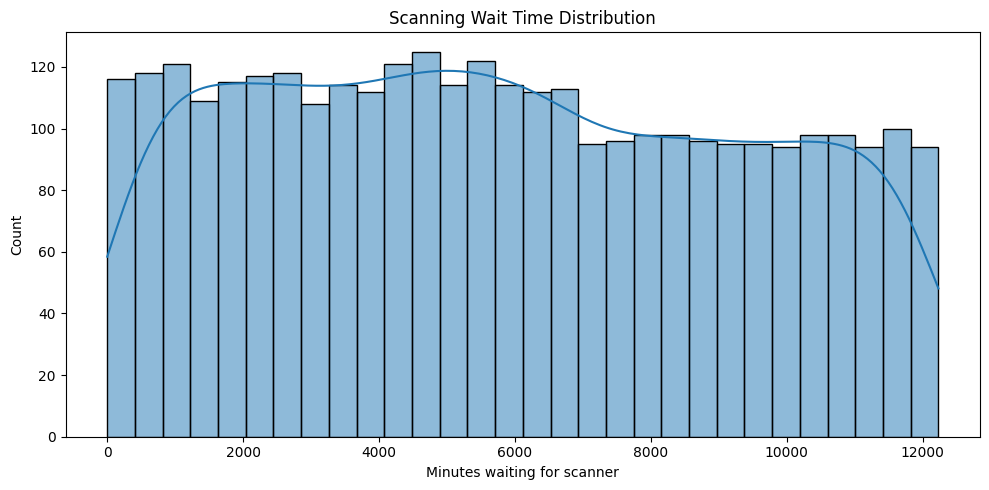

Saved: figures\run_20251128_191124\scan_wait.png


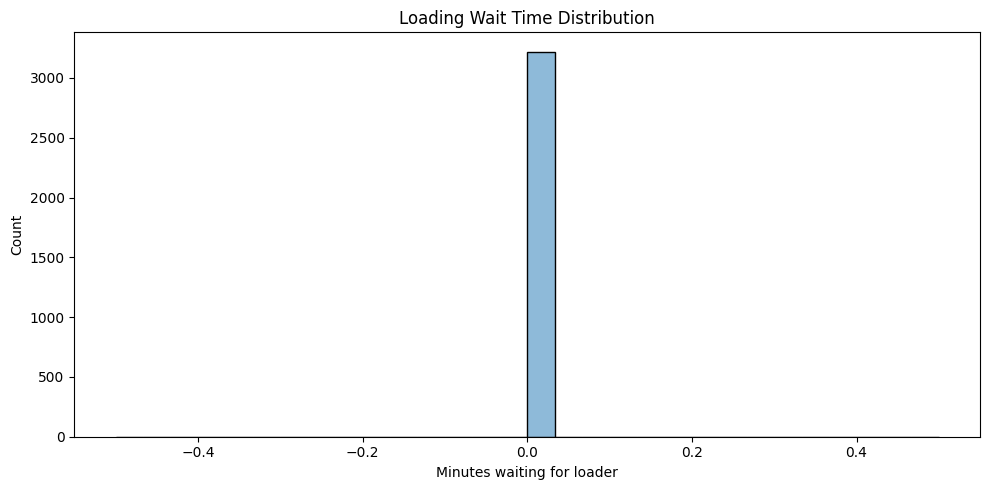

Saved: figures\run_20251128_191124\loading_wait.png


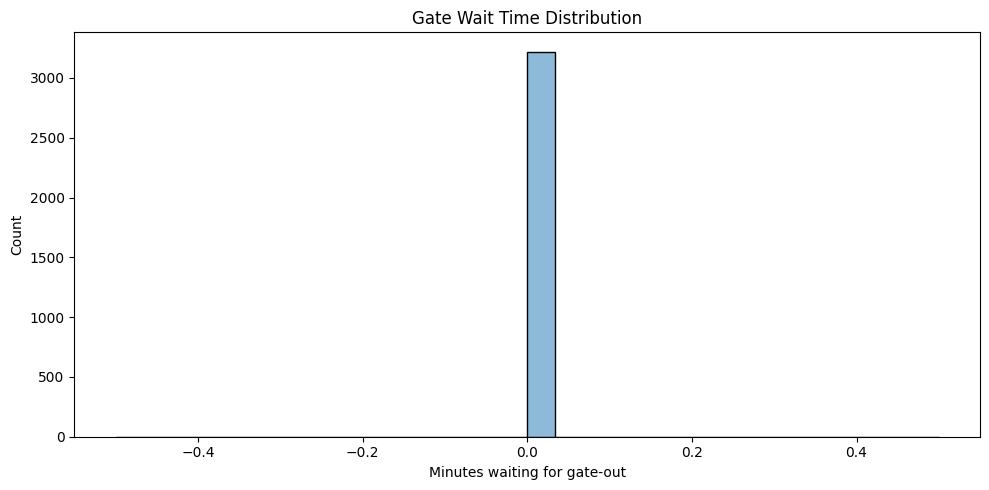

Saved: figures\run_20251128_191124\gate_wait.png


In [15]:
# -----------------------------------------
# Plot metrics and save figures per run
# -----------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import datetime as dt

df = metrics_to_dataframe()

# Skip if nothing to plot
if df.empty:
    print("No completed containers to plot yet.")
else:
    # Create a per-run folder
    run_stamp = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
    fig_dir = Path("figures") / f"run_{run_stamp}"
    fig_dir.mkdir(parents=True, exist_ok=True)

    def plot_metric(df, column, title, xlabel, filename):
        if column not in df.columns:
            print(f"Skipping {column}: column not found.")
            return
        plt.figure(figsize=(10, 5))
        sns.histplot(df[column], kde=True, bins=30)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel("Count")
        out = fig_dir / filename
        plt.tight_layout()
        plt.savefig(out, dpi=150)
        plt.show()
        print(f"Saved: {out}")

    plot_metric(df, "scan_wait",
                "Scanning Wait Time Distribution",
                "Minutes waiting for scanner",
                "scan_wait.png")

    plot_metric(df, "loading_wait",
                "Loading Wait Time Distribution",
                "Minutes waiting for loader",
                "loading_wait.png")

    plot_metric(df, "gate_wait",
                "Gate Wait Time Distribution",
                "Minutes waiting for gate-out",
                "gate_wait.png")


**What this does**
- Regenerates `df` from completed containers; skips plotting if empty.
- Creates a timestamped folder under `figures/run_YYYYMMDD_HHMMSS` for this run.
- Plots histograms (with KDE) for scan, loading, and gate waits; saves each PNG into the run folder and reports the saved paths.


# Improved Dwell Container Process

In [16]:
# -----------------------------------------
# Run Improved Dwell Simulation
# -----------------------------------------

# Reset metrics for improved run
METRICS_IMPROVED = []

# Custom record function for improved dwell run
def record_metrics_improved(container_id, timestamps):
    METRICS_IMPROVED.append({
        "container_id": container_id,
        **timestamps
    })

# Wrap the improved container process to use the improved recorder
def container_process_improved_wrapper(env, container_id, cranes, yard, scanners, loaders, gates):
    # Use the improved version but record with improved metrics list
    t = {}
    t["arrival_time"] = env.now

    # 1. Crane Offloading
    with cranes.request() as req:
        yield req
        t["crane_start"] = env.now
        yield env.timeout(CRANE_TIME)
        t["crane_end"] = env.now

    # 2. Yard Entry
    yard_req = yard.put(1)
    yield yard_req
    t["yard_entry_time"] = env.now

    # 3. Improved Yard Dwell
    dwell_time = random.choice([
        2 * 24 * 60, 
        3 * 24 * 60, 
        4 * 24 * 60
    ])
    yield env.timeout(dwell_time)
    t["yard_exit_time"] = env.now

    # 4. Scanning
    with scanners.request() as req:
        t["scan_queue_enter"] = env.now
        yield req
        t["scan_start"] = env.now
        yield env.timeout(SCAN_TIME)
        t["scan_end"] = env.now

    # 5. Loading
    with loaders.request() as req:
        t["loading_queue_enter"] = env.now
        yield req
        t["loading_start"] = env.now
        yield env.timeout(LOADING_TIME)
        t["loading_end"] = env.now

    yield yard.get(1)

    # 6. Gate-Out
    with gates.request() as req:
        t["gate_queue_enter"] = env.now
        yield req
        t["gate_start"] = env.now
        yield env.timeout(GATE_TIME)
        t["exit_time"] = env.now

    # Save metrics
    record_metrics_improved(container_id, t)


# ---------------------------------------------------
# Create new environment for improved dwell simulation
# ---------------------------------------------------
env2 = simpy.Environment()

cranes2 = simpy.Resource(env2, capacity=NUM_CRANES)
yard2 = simpy.Container(env2, capacity=YARD_CAPACITY, init=0)
scanners2 = simpy.Resource(env2, capacity=NUM_SCANNERS)
loaders2 = simpy.Resource(env2, capacity=NUM_LOADING_BAYS)
gates2 = simpy.Resource(env2, capacity=NUM_GATE_LANES)

# Run improved arrival generator
def arrival_generator_improved(env, cranes, yard, scanners, loaders, gates, stop_time):
    container_id = 0
    while True:
        interarrival = random.expovariate(1/5)
        yield env.timeout(interarrival)
        if env.now >= stop_time:
            break
        env.process(
            container_process_improved_wrapper(env, container_id, cranes, yard, scanners, loaders, gates)
        )
        container_id += 1

# Start improved traffic and run
env2.process(arrival_generator_improved(env2, cranes2, yard2, scanners2, loaders2, gates2, SIM_TIME))
env2.run(until=SIM_TIME + MAX_DWELL + POST_PROCESS_BUFFER)

print("Improved dwell simulation complete.")

Improved dwell simulation complete.


# Convert improved metrics to dataframe

In [17]:
# -----------------------------------------
# Convert Improved Metrics to DataFrame
# -----------------------------------------

def metrics_to_dataframe_improved():
    df2 = pd.DataFrame(METRICS_IMPROVED)

    df2["total_time"] = df2["exit_time"] - df2["arrival_time"]
    df2["yard_dwell"] = df2["yard_exit_time"] - df2["yard_entry_time"]
    df2["scan_wait"] = df2["scan_start"] - df2["yard_exit_time"]
    df2["loading_wait"] = df2["loading_start"] - df2["scan_end"]
    df2["gate_wait"] = df2["gate_start"] - df2["loading_end"]

    return df2

df_improved = metrics_to_dataframe_improved()
df_improved.head()

,container_id,arrival_time,crane_start,crane_end,yard_entry_time,yard_exit_time,scan_queue_enter,scan_start,scan_end,loading_queue_enter,loading_start,loading_end,gate_queue_enter,gate_start,exit_time,total_time,yard_dwell,scan_wait,loading_wait,gate_wait
0,0,3.143497,3.143497,6.476830,6.476830,2886.476830,2886.476830,2886.476830,2896.476830,2896.476830,2896.476830,2973.476830,2973.476830,2973.476830,2980.476830,2977.333333,2880.0,0.0,0.0,0.0
1,2,16.050627,16.050627,19.383960,19.383960,2899.383960,2899.383960,2899.383960,2909.383960,2909.383960,2909.383960,2986.383960,2986.383960,2986.383960,2993.383960,2977.333333,2880.0,0.0,0.0,0.0
2,3,16.125874,16.125874,19.459208,19.459208,2899.459208,2899.459208,2899.459208,2909.459208,2909.459208,2909.459208,2986.459208,2986.459208,2986.459208,2993.459208,2977.333333,2880.0,0.0,0.0,0.0
3,8,45.421112,45.421112,48.754446,48.754446,2928.754446,2928.754446,2928.754446,2938.754446,2938.754446,2938.754446,3015.754446,3015.754446,3015.754446,3022.754446,2977.333333,2880.0,0.0,0.0,0.0
4,12,52.136616,52.136616,55.469949,55.469949,2935.469949,2935.469949,2935.469949,2945.469949,2945.469949,2945.469949,3022.469949,3022.469949,3022.469949,3029.469949,2977.333333,2880.0,0.0,0.0,0.0


# Side-by-Side Comparison Plots

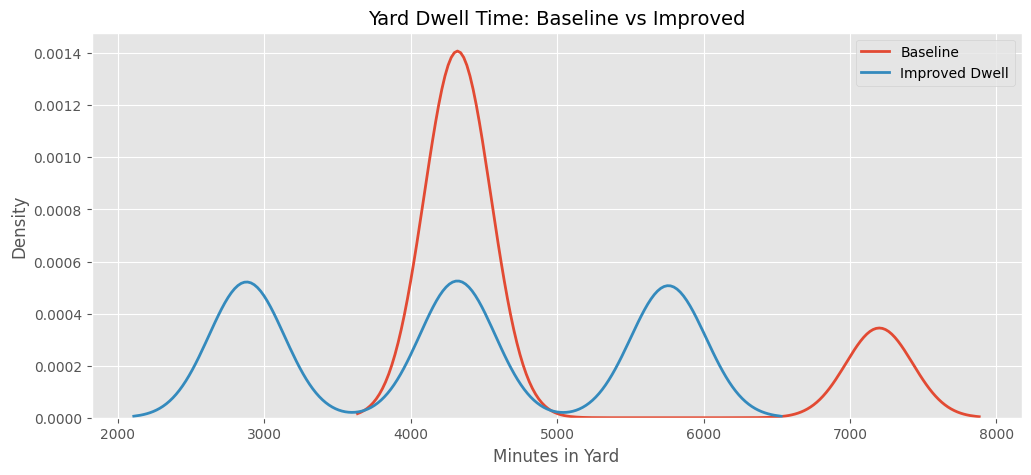

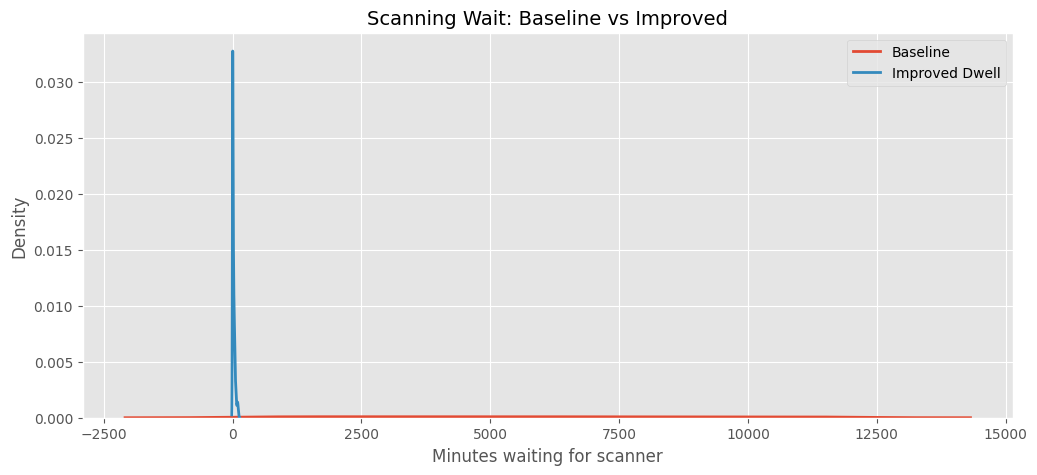

C:\Users\nkany\AppData\Local\Temp\ipykernel_14548\2824388063.py:13: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df1[column], label="Baseline", linewidth=2)
C:\Users\nkany\AppData\Local\Temp\ipykernel_14548\2824388063.py:14: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df2[column], label="Improved Dwell", linewidth=2)
C:\Users\nkany\AppData\Local\Temp\ipykernel_14548\2824388063.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


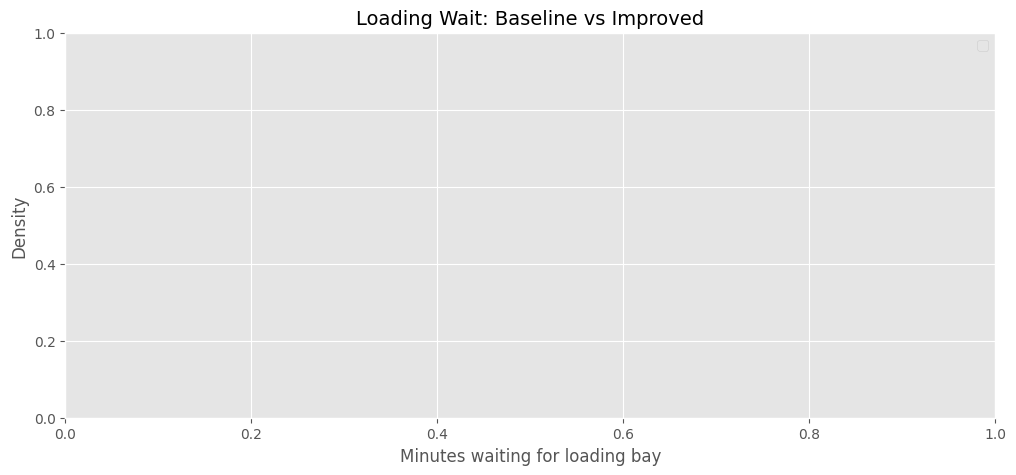

C:\Users\nkany\AppData\Local\Temp\ipykernel_14548\2824388063.py:13: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df1[column], label="Baseline", linewidth=2)
C:\Users\nkany\AppData\Local\Temp\ipykernel_14548\2824388063.py:14: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df2[column], label="Improved Dwell", linewidth=2)
C:\Users\nkany\AppData\Local\Temp\ipykernel_14548\2824388063.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


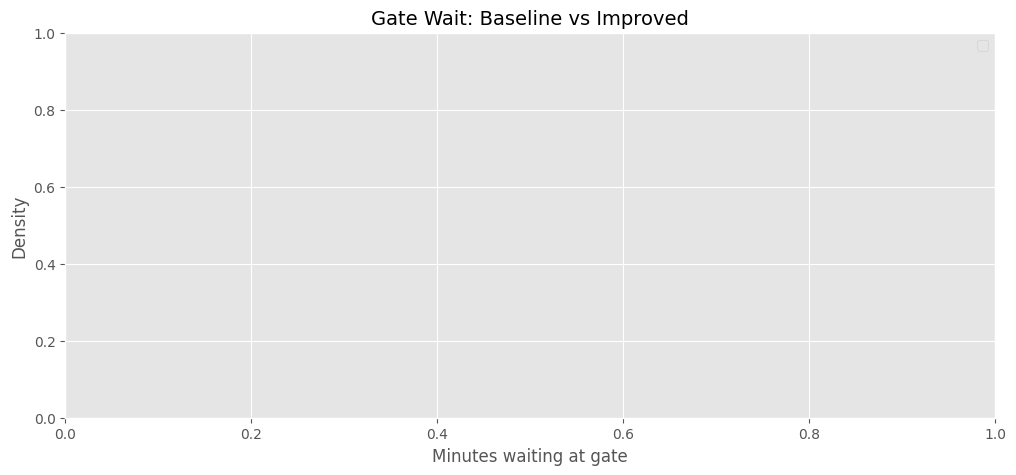

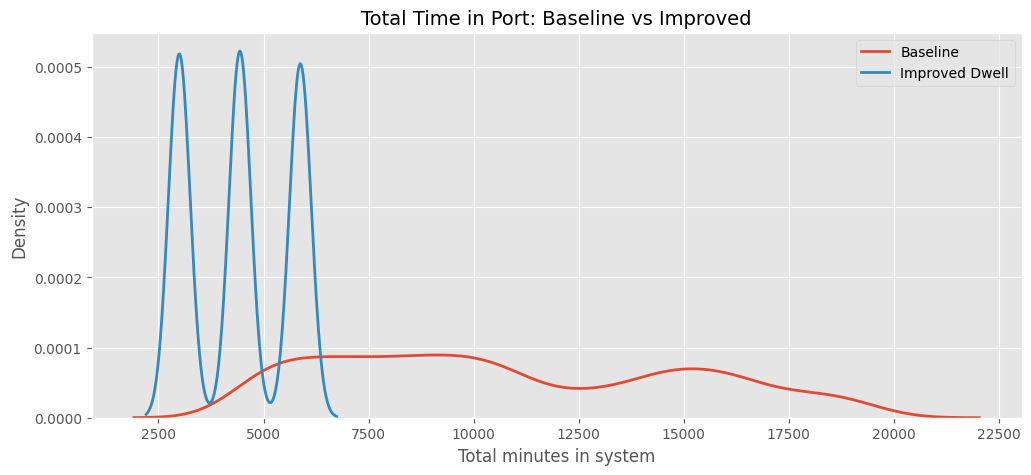

In [18]:
# -----------------------------------------
# Compare Baseline vs Improved Dwell
# -----------------------------------------

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")

def compare_distributions(df1, df2, column, title, xlabel):
    plt.figure(figsize=(12,5))
    
    sns.kdeplot(df1[column], label="Baseline", linewidth=2)
    sns.kdeplot(df2[column], label="Improved Dwell", linewidth=2)
    
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel)
    plt.ylabel("Density")
    plt.legend()
    plt.show()


# Yard dwell time comparison
compare_distributions(df, df_improved,
                      "yard_dwell",
                      "Yard Dwell Time: Baseline vs Improved",
                      "Minutes in Yard")


# Scanning wait comparison
compare_distributions(df, df_improved,
                      "scan_wait",
                      "Scanning Wait: Baseline vs Improved",
                      "Minutes waiting for scanner")


# Loading wait comparison
compare_distributions(df, df_improved,
                      "loading_wait",
                      "Loading Wait: Baseline vs Improved",
                      "Minutes waiting for loading bay")


# Gate wait comparison
compare_distributions(df, df_improved,
                      "gate_wait",
                      "Gate Wait: Baseline vs Improved",
                      "Minutes waiting at gate")


# Total system time
compare_distributions(df, df_improved,
                      "total_time",
                      "Total Time in Port: Baseline vs Improved",
                      "Total minutes in system")


### **Comparison: Baseline vs Improved Yard Dwell**

These plots compare the baseline simulation and the improved-dwell simulation.

The goal is to show how reducing yard dwell time affects:

- overall throughput  
- queue lengths  
- system congestion  
- end-to-end transit time  



#### **1. Yard Dwell**
This should show a significant left-shift (shorter dwell times).

#### **2. Scanning Wait**
Reduced yard congestion allows containers to reach scanning earlier.

#### **3. Loading Wait**
Lower yard occupancy improves container accessibility for loading.

#### **4. Gate Wait**
Gate-out is fast, but improvements upstream reduce peaks.

#### **5. Total Time in System**
This is the most important KPI —  
a large reduction here validates operational impact.

These will form the graphs used in the report and presentation.


# Compute Numerical Improvements

In [21]:
# -----------------------------------------
# Numerical Performance Improvements
# -----------------------------------------

def percentage_change(before, after):
    """Percent reduction; handles zero to avoid divide-by-zero warnings."""
    # Normalize to plain floats to avoid np.float64 in output.
    before = float(before)
    after = float(after)
    if before == 0:
        if after == 0:
            return 0.0
        return float('nan')
    return float(round(((before - after) / before) * 100, 2))

results = {}

# Mean values
results["Mean Total Time Reduction (%)"] = percentage_change(
    df["total_time"].mean(),
    df_improved["total_time"].mean()
)

results["Mean Yard Dwell Reduction (%)"] = percentage_change(
    df["yard_dwell"].mean(),
    df_improved["yard_dwell"].mean()
)

results["Mean Scanning Wait Reduction (%)"] = percentage_change(
    df["scan_wait"].mean(),
    df_improved["scan_wait"].mean()
)

results["Mean Loading Wait Reduction (%)"] = percentage_change(
    df["loading_wait"].mean(),
    df_improved["loading_wait"].mean()
)

results["Mean Gate Wait Reduction (%)"] = percentage_change(
    df["gate_wait"].mean(),
    df_improved["gate_wait"].mean()
)

results


{'Mean Total Time Reduction (%)': 59.13,
 'Mean Yard Dwell Reduction (%)': 11.85,
 'Mean Scanning Wait Reduction (%)': 99.66,
 'Mean Loading Wait Reduction (%)': 0.0,
 'Mean Gate Wait Reduction (%)': 0.0}

### **Numerical Performance Improvements**

This table quantifies how much performance improves under the reduced dwell policy.

We measure:

- average total time in the port  
- average yard dwell time  
- average scanning wait  
- average loading wait  
- average gate wait  

Each is expressed as a **percentage reduction** relative to baseline.

This forms the core of your optimisation results for the report.
